# GAN For Image Synthesis

### Step 1

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [20]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))      # Normalize pixel values (-1 to 1)
])

# Load CIFAR-10 dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Get class labels
classes = trainset.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Class Labels:", classes)


Class Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


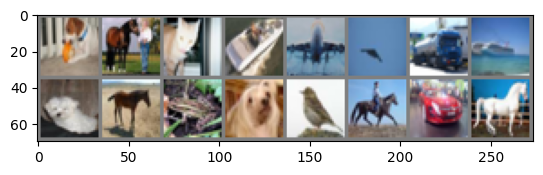

Labels: ['dog', 'horse', 'cat', 'ship', 'airplane', 'airplane', 'truck', 'ship', 'dog', 'horse', 'frog', 'dog', 'bird', 'horse', 'automobile', 'horse']


In [21]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16]))
print("Labels:", [classes[labels[i]] for i in range(16)])


### Step 2

In [22]:
# class Generator(nn.Module):
#     def __init__(self, noise_dim, num_classes, img_channels):
#         super(Generator, self).__init__()
        
#         self.label_embedding = nn.Embedding(num_classes, noise_dim)  # Embed labels
        
#         self.model = nn.Sequential(
#             nn.Linear(noise_dim * 2, 256),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, img_channels * 32 * 32),  # Output image size
#             nn.Tanh()  # Output range [-1,1]
#         )

#     def forward(self, noise, labels):
#         label_embedding = self.label_embedding(labels)  # Embed label
#         gen_input = torch.cat((noise, label_embedding), dim=1)  # Concatenate noise & label
#         img = self.model(gen_input)
#         img = img.view(img.size(0), 3, 32, 32)  # Reshape to image format
#         return img


In [23]:


class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super(Generator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, noise_dim)  # Embed labels

        self.model = nn.Sequential(
            nn.Linear(noise_dim * 2, 512 * 4 * 4),  # Project noise vector
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),  # Reshape to CNN input (512x4x4)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output 64x64 image
            nn.Tanh()  # Normalize to range [-1,1]
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)  # Convert label to embedding
        x = torch.cat([noise, label_embedding], dim=1)  # Concatenate noise & label
        img = self.model(x)
        return img  # Output shape: (batch, 3, 64, 64)

print("✅ Updated Generator Model with Convolutional Layers!")


✅ Updated Generator Model with Convolutional Layers!


In [24]:
# class Discriminator(nn.Module):
#     def __init__(self, num_classes, img_channels):
#         super(Discriminator, self).__init__()
        
#         self.label_embedding = nn.Embedding(num_classes, img_channels * 32 * 32)  # Embed labels

#         self.model = nn.Sequential(
#             nn.Linear(img_channels * 32 * 32 + img_channels * 32 * 32, 1024),
#             nn.LeakyReLU(0.2),
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 1),
#             nn.Sigmoid()  # Output probability (real/fake)
#         )

#     def forward(self, img, labels):
#         label_embedding = self.label_embedding(labels)  # Embed label
#         d_input = torch.cat((img.view(img.size(0), -1), label_embedding), dim=1)  # Flatten and concatenate
#         validity = self.model(d_input)
#         return validity


In [25]:

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_channels):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, img_channels * 32 * 32)  # Embed labels

        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, kernel_size=4, stride=2, padding=1),  # Input image + label channel
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1),  # Adjust based on image resolution
            nn.Sigmoid()  # Output probability (real/fake)
        )

    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels).view(-1, 1, 32, 32)  # Reshape labels to match image size
        img = torch.cat((img, label_embedding), dim=1)  # Concatenate label as additional channel
        validity = self.model(img)
        return validity

print("✅ Updated Discriminator Model with Convolutional Layers!")


✅ Updated Discriminator Model with Convolutional Layers!


In [26]:
# Set hyperparameters
noise_dim = 100  # Size of the noise vector
num_classes = 10  # CIFAR-10 has 10 classes
img_channels = 3  # RGB images

# Initialize updated models
generator = Generator(noise_dim, num_classes)  # Use Improved Generator
discriminator = Discriminator(num_classes, img_channels)  # Use Improved Discriminator

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

print("✅ Updated Generator & Discriminator initialized!")


✅ Updated Generator & Discriminator initialized!


### Step 3

In [27]:
# Loss function
# criterion = nn.BCELoss()

# # Learning rate
# lr = 0.0002

# # Optimizers
# optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [28]:
criterion = nn.BCEWithLogitsLoss()  # More stable than BCELoss

# Learning rates
lr_G = 0.0002  # Generator learning rate
lr_D = 0.0001  # Lower learning rate for Discriminator (stabilizes training)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))

print("✅ Loss function & optimizers set up successfully!")


✅ Loss function & optimizers set up successfully!


In [29]:
# def get_random_noise(batch_size, noise_dim):
#     return torch.randn(batch_size, noise_dim).to(device)  # Random noise vector

# def get_random_labels(batch_size, num_classes):
#     return torch.randint(0, num_classes, (batch_size,)).to(device)  # Random class labels


In [30]:
def get_random_noise(batch_size, noise_dim):
    """Generate random noise vector for the generator."""
    return torch.randn(batch_size, noise_dim, device=device).detach()  # No gradients needed

def get_random_labels(batch_size, num_classes):
    """Generate random class labels for conditional generation."""
    return torch.randint(0, num_classes, (batch_size,), device=device, dtype=torch.long)  # Ensure correct dtype

print("✅ Noise & Label generation functions are optimized!")


✅ Noise & Label generation functions are optimized!


In [31]:
# # Training parameters
# num_epochs = 300  # Set number of epochs
# batch_size = 32  # Batch size

# # Training loop
# for epoch in range(num_epochs):
#     for i, (real_imgs, labels) in enumerate(trainloader):
        
#         batch_size = real_imgs.size(0)
        
#         # Move data to device
#         real_imgs, labels = real_imgs.to(device), labels.to(device)

#         ## ---- TRAIN DISCRIMINATOR ---- ##
#         optimizer_D.zero_grad()

#         # Real image loss
#         real_targets = torch.ones(batch_size, 1).to(device)  # Labels = 1 (Real)
#         real_loss = criterion(discriminator(real_imgs, labels), real_targets)

#         # Generate fake images
#         noise = get_random_noise(batch_size, noise_dim)
#         fake_labels = get_random_labels(batch_size, num_classes)
#         fake_imgs = generator(noise, fake_labels)

#         # Fake image loss
#         fake_targets = torch.zeros(batch_size, 1).to(device)  # Labels = 0 (Fake)
#         fake_loss = criterion(discriminator(fake_imgs.detach(), fake_labels), fake_targets)

#         # Total loss for Discriminator
#         d_loss = real_loss + fake_loss
#         d_loss.backward()
#         optimizer_D.step()

#         ## ---- TRAIN GENERATOR ---- ##
#         optimizer_G.zero_grad()

#         # Generate fake images again
#         noise = get_random_noise(batch_size, noise_dim)
#         fake_labels = get_random_labels(batch_size, num_classes)
#         fake_imgs = generator(noise, fake_labels)

#         # Generator loss (try to fool Discriminator)
#         g_loss = criterion(discriminator(fake_imgs, fake_labels), real_targets)  # Real label = 1
#         g_loss.backward()
#         optimizer_G.step()

#     # Print loss for monitoring
#     print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {d_loss.item():.4f}  Loss_G: {g_loss.item():.4f}")

# print("✅ Training Complete!")


In [32]:
# Training parameters
num_epochs = 300  # Number of epochs
batch_size = 32 # Batch size

# Learning rate scheduler for stability
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.5)

# Training loop
for epoch in range(num_epochs):
    for i, (real_imgs, labels) in enumerate(trainloader):
        
        batch_size = real_imgs.size(0)
        
        # Move data to device
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        ## ---- TRAIN DISCRIMINATOR ---- ##
        optimizer_D.zero_grad()

        # Real image loss (Label smoothing: 0.9 instead of 1.0)
        real_targets = torch.full((batch_size, 1), 0.9, device=device)  
        real_loss = criterion(discriminator(real_imgs, labels), real_targets)

        # Generate fake images
        noise = get_random_noise(batch_size, noise_dim)
        fake_labels = get_random_labels(batch_size, num_classes)
        fake_imgs = generator(noise, fake_labels).detach()  # Detach to prevent Generator update

        # Fake image loss
        fake_targets = torch.zeros(batch_size, 1, device=device)  # Labels = 0 (Fake)
        fake_loss = criterion(discriminator(fake_imgs, fake_labels), fake_targets)

        # Total loss for Discriminator
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        ## ---- TRAIN GENERATOR ---- ##
        optimizer_G.zero_grad()

        # Generate fake images again
        noise = get_random_noise(batch_size, noise_dim)
        fake_labels = get_random_labels(batch_size, num_classes)
        fake_imgs = generator(noise, fake_labels)

        # Generator loss (tries to fool Discriminator)
        g_loss = criterion(discriminator(fake_imgs, fake_labels), real_targets)  
        g_loss.backward()
        optimizer_G.step()

    # Update learning rate scheduler
    scheduler_G.step()
    scheduler_D.step()

    # Print loss for monitoring
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {d_loss.item():.4f}  Loss_G: {g_loss.item():.4f}")

print("✅ Training Complete!")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 384 for tensor number 1 in the list.

In [1]:
import torchvision.utils as vutils

# Function to generate and display images
def generate_images(generator, num_samples=10):
    generator.eval()  # Set to evaluation mode
    
    noise = get_random_noise(num_samples, noise_dim)  # Generate random noise
    labels = torch.arange(num_samples) % num_classes  # Generate labels (0-9 for CIFAR-10)
    labels = labels.to(device)

    with torch.no_grad():  # No gradients needed for inference
        fake_imgs = generator(noise, labels)

    # Unnormalize and plot
    fake_imgs = (fake_imgs + 1) / 2  # Scale from [-1,1] to [0,1]
    grid = vutils.make_grid(fake_imgs, nrow=5, padding=2, normalize=False)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

# Generate and display images
generate_images(generator)


NameError: name 'generator' is not defined

In [3]:

torch.save(generator.state_dict(), "cgan_generator.pth")
torch.save(discriminator.state_dict(), "cgan_discriminator.pth")
print("✅ Models saved successfully!")


NameError: name 'torch' is not defined

In [ ]:
# Reload the generator model
generator.load_state_dict(torch.load("cgan_generator.pth", map_location=device))
generator.eval()  # Set to evaluation mode

# Generate images again
generate_images(generator)


In [ ]:
# Convert the generator to TorchScript
generator_scripted = torch.jit.script(generator)

# Save the TorchScript model
generator_scripted.save("cgan_generator_scripted.pt")

print("✅ TorchScript model exported successfully!")


NameError: name 'torch' is not defined

In [14]:
# import torch.onnx

# # Define a dummy input for tracing
# dummy_noise = torch.randn(1, noise_dim).to(device)  # Random noise vector
# dummy_label = torch.randint(0, num_classes, (1,)).to(device)  # Random label

# # Export to ONNX
# torch.onnx.export(generator, 
#                   (dummy_noise, dummy_label), 
#                   "cgan_generator.onnx", 
#                   input_names=["noise", "label"], 
#                   output_names=["generated_image"],
#                   dynamic_axes={"noise": {0: "batch_size"}, "label": {0: "batch_size"}})

# print("✅ ONNX model exported successfully!")
